# Notebook 2.7.1: Glucose (The Minimal Model)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


In this notebook we'll start a new example: a model of how glucose and insulin interact to control blood sugar. We will implement a widely used model called the "minimal model" because it is intended to include only the elements essential to explain the observed behavior of the system.


## Investigating the Minimal Model for Glucose and Insulin

### The Glucose-Insulin Interaction

*Pharmacokinetics* is the study of how drugs and other substances move around the body, react, and are eliminated. This notebook presents a widely used pharmacokinetic model of glucose and insulin in the blood stream.

<br>

*Glucose* is a form of sugar that circulates in the blood of animals; it is used as fuel for muscles, the brain, and other organs. The concentration of blood sugar is controlled by the hormone system, and especially by *insulin*, which is produced by the pancreas and has the effect of reducing blood sugar.

<br>

In people with normal pancreatic function, the hormone system maintains *homeostasis*; that is, it keeps the concentration of blood sugar in a range that is neither too high or too low.  But if the pancreas does not produce enough insulin, blood sugar can
become elevated, a condition called *hyperglycemia*. Long term, severe hyperglycemia is the defining symptom of *diabetes mellitus*, a serious disease that affects almost 10% of the population in the U.S.

<br>

A widely used test for hyperglycemia and diabetes is the
frequently sampled intravenous glucose tolerance test (FSIGT), in which glucose is injected into the blood stream of a fasting subject (someone who has not eaten recently); then blood samples are collected at intervals of 2--10 minutes for 3 hours. The samples are analyzed to measure the concentrations of glucose and insulin; this analysis gives us a sense of how well the body is responding to increased glucose levels.

✅ Active Reading: What is the relationship between insulin levels, sugar levels, and hyperglycemia?

✅ ✅  Answer here

### The Glucose Minimal Model

The minimal model, as proposed by Bergman, Ider, Bowden, and
Cobelli, was developed in the 1970s; since then, many
variations and extensions have been proposed. Bergman and his colleagues aimed to describe the simplest model they could that could effectively accuont for the insulin-glucose relationship found in experimental data.

<br>

They thought it was essential to capture two characteristics of the glucose-insulin interaction:

<br>

* When glucose is injected into the blood, glucose levels in the blood should go up quickly and then should return back to a "base" level.  This "return to normal" happens in two ways.  First glucose will naturally move out of the blood stream, and second, insulin encourages (or "catalyzes") this "glucose disposal" process.

<br>
 
* The effect of insulin on glucose disposal, as seen in the data, happens more slowly than we would expect if it depended primarily on the the concentration of insulin in the blood. Bergman's group hypothesized that insulin must move relatively slowly from the blood to a "remote compartment"; only when in this "compartment" can it affect glucose levels in the body.

<br>

Interestingly, at the time, the "remote compartment" was a modeling abstraction that might, or might not, represent something physical. Later, this compartment was shown to be interstitial fluid, that is, the fluid
that surrounds tissue cells.  In the history of mathematical modeling, it is common for hypothetical entities, added to models to achieve particular effects, to be found later to correspond to physical entities.  [One notable example is the gene.](https://en.wikipedia.org/wiki/Gene#Discovery_of_discrete_inherited_units)

<br>

The implication is that to model this system and describe its *state*, we need to keep track of 3 variables: 

* the concentration $G$ of glucose in the blood

* the concentration $I$ of insulin in the blood 

* the concentration $X$ of insulin in the tissue fluid 

In the minimal model, $I$ is a measured value that is used as an input to the model (as opposed to $G$ and $X$, which are variables).  When at high levels, the insulin in the blood will diffuse into the tissue.

✅  Active reading: Why is it necessary to keep track of insulin in two different places? 

✅ ✅  Answer here

### Putting the model into differential form

Our simulation will track the state of our system ($G$ and $X$) during a FSIGT test: that is, after glucose is injected into the blood.  To do this, we will need to incorporate two differential equations into the simulation:

<br>

$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

<br>

$$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$ 

<br>

The constants in this equation include:

* $G_b$ is the basal concentration of blood glucose (that is, the glucose concentrations at equilibrium. This is estimated from measurements at the beginning or end of the test.

* $I_b$ is the basal concentration of blood insulin.

* $k_1$, $k_2$, and $k_3$ are positive-valued parameters that control the rates of appearance and disappearance for glucose and insulin.

We can interpret the terms in the equations one by one:

<br>

-   $-k_1 \left[ G(t) - G_b \right]$ is the rate of glucose change due to the natural self-balancing of the glucose. When $G(t)$ is above basal level, $G_b$, this term is negative; when $G(t)$ is below basal level this term is positive. So in the absence of insulin, this term tends to restore blood glucose to basal level.

-   $-X(t) G(t)$ models the interaction of glucose and insulin in tissue fluid, so the rate increases as either $X$ or $G$ increases. This term does not require a rate parameter because the units of $X$ are unspecified; we can consider $X$ to be in whatever units make the parameter of this term 1.

-   $k_3 \left[ I(t) - I_b \right]$ is the rate at which insulin diffuses between blood and tissue fluid (where it can help dispose of glucose). When $I(t)$ is above basal level $I_b$, insulin diffuses from the blood into the tissue fluid. When $I(t)$ is below basal level, insulin diffuses from tissue to the blood.

-   $-k_2 X(t)$ is the rate of insulin disappearance in tissue fluid as it is consumed or broken down.

<br>

The initial state of the model is:

* $X(0) = I_b$, which means that the level of insulin in the tissue at equilibrium with the basal level of insulin in the blood.
* $G(0) = G_0$, where $G_0$ is a constant that represents the concentration of blood sugar immediately after the injection. Since $G_0$ is difficult to measure, it is treated as a *free parameter* of the model, which means that we are free to choose it to fit the data.

✅  Active reading:  What happens to the glucose levels in the blood when those levels are higher than the base glucose level?  Where do you see this in the differential equations?

✅ ✅  Answer here



---

<br>

## Getting the Data

To develop and test the model, we'll use data from a 1986 paper by Pacini and Bergman, which provides experimental data about glucose and insulin levels after a FSIGT test.  We can use Pandas to read the data file, and inspect the first few rows:

In [ ]:
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/glucose_insulin.csv'
# If you are using this notebook offline, you will need to upload this data
# from the Images_and_Data folder.  Comment out the line above, and uncomment the
# line below this one, and run this cell
# filename = '../Images_and_Data/Data/glucose_insulin.csv'

data = pd.read_csv(filename, index_col='time')
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


`data` has two columns: `glucose` is the concentration of blood glucose in mg/dL; `insulin` is the concentration of insulin in the blood in $\mu$U/mL (a medical "unit", denoted U, is an amount defined by convention in context). The index is time in minutes. This dataset represents glucose and insulin concentrations over
182 minutes for a subject with normal insulin production and sensitivity.

### Interpolation

Before we are ready to use the data, there's one problem we have to solve. In the `DataFrame`, we only have measurements at discrete times ($t=0,2,6...$). Making this even more complicated, the time steps in our data file are not regular: that is, the step is not always 2 minutes, as we can see here:

In [ ]:
print(data.index)

Int64Index([  0,   2,   4,   6,   8,  10,  12,  14,  16,  19,  22,  27,  32,
             42,  52,  62,  72,  82,  92, 102, 122, 142, 162, 182],
           dtype='int64', name='time')


But because $I(t)$ is an input into our model, we need to be able to access the value of $I$ at any time step.  The solution is interpolation, which estimates the value of $I$ for values of $t$ between the measured data.  The SciPy library provides an interpolate function called `interp1d` (that is interpolating in 1 dimension).  It takes a `Series` as a parameter and returns a mathematical function (That's right, it returns a *function*!) that can find the value of the Series at any time point. We can call it like this:

In [ ]:
from scipy.interpolate import interp1d

# The x values are the index from the Series (here, 'Time').
# The y values are the values from the Series (here, insulin concentration)

Insulin_func = interp1d(data.insulin.index,data.insulin.values)

The result is a function we can call like this:

In [ ]:
t = 7.5
print("The insulin level at time", t, "is", Insulin_func(t))
data.head()

The insulin level at time 7.5 is 59.5


,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


In this example the interpolated value is about 59.5, which is a linear interpolation between the actual measurements at `t=6` and `t=8`.  Check that this makes sense by looking values for insulin in `data`; check some other values for `t`.  

<br>

We can also pass an array as an argument to our function.  Here we create an array of equally-spaced values from `t_0` to `t_end`.  By using that array as an argument for our function, we create a new array that gives us values for `insulin` at an array of time steps.

In [ ]:
t_0 = data.index[0]
t_end = data.index[-1]
t_array = np.arange(t_0, t_end+1,1)
I_array = Insulin_func(t_array)

We can put the results in a `Series`, and plot our results next to the original data.  Notice the `style` used to plot the discrete points of `data`.

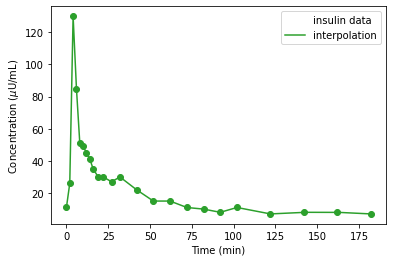

In [ ]:
I_series = pd.Series(data=I_array, index=t_array)

data.insulin.plot(style='o', color='C2', label='insulin data',
                 legend=True)
I_series.plot(color='C2', label='interpolation',
              xlabel='Time (min)',
              ylabel='Concentration ($\mu$U/mL)',
             legend=True);

Linear interpolation connects the dots with straight lines, and for this dataset that's probably good enough. As an exercise, below, you can try out other kinds of interpolation.

---

## Summary

This notebook introduces a model of the interaction between glucose and insulin in the blood stream, and a a new tool, interpolation, which we'll need to implement the model.   In the next notebook, we will use measured concentrations of insulin to simulate the glucose-insulin system, and compare the results to measured concentrations of glucose.

<br>

---

## Exercises


### Exercise 1

`interpolate` is a wrapper for the SciPy function `interp1d`.
Read the documentation of `interp1d` [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html). In particular, notice the `kind` argument, which specifies a kind of interpolation.  The default is linear interpolation, which connects the data points with straight lines.

<br>

Pass a keyword argument to `interpolate` to specify one of the other kinds of interpolation, and run the code again to see what it looks like.  Put the lines of code under the proper line comment in the first cell (to make sure you understand what the code is doing).

<br>

Notice that these exercises are not asking you to make a lot of changes! you'll be able to largely use the code we used above, with a couple small changes.

In [ ]:
# Use interp1d to create a new function (just as we did above)



# Create a time array t_array that defines a data point for each minute



# Create an array that finds the values of the interpolated function you made at 
# each time step in t_array


# Create a Series called I1_series using your two arrays


NameError: ignored

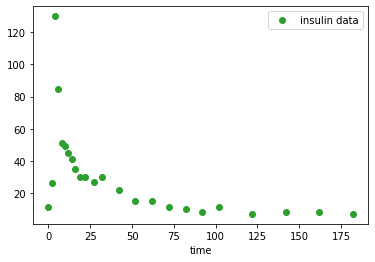

In [ ]:
# Here's the plotting code again.

data.insulin.plot(style='o', color='C2', label='insulin data',
                 legend=True)
I1_series.plot(color='C2', label='interpolation',
              xlabel='Time (min)',
              ylabel='Concentration ($\mu$U/mL)',
             legend=True);

### Exercise 2

 Interpolate the glucose data and generate a plot, similar to the previous one, that shows the data points and the interpolated curve evaluated at the time values in `t_array`.

In [ ]:
# Create a Series G1_series with interpolated data from the 
# experimental glucose data.  Use whichever 'kind' of interpolation
# you would like


In [ ]:
# Plot the data

data.glucose.plot(style='o', color='C4', label='glucose data',
                 legend=True)
G1_series.plot(color='C4', label='interpolation',
               xlabel='Time (min)',
               ylabel='Concentration ($\mu$U/mL)',
              legend=True);